In [30]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory

from skimage import measure
from skimage.io import imread, imsave, imshow
from skimage.transform import resize
from skimage.filters import gaussian
from skimage.morphology import dilation, disk
from skimage.draw import polygon, polygon_perimeter

import cv2

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.config.list_physical_devices("GPU") else "OFF" }')

Tensorflow version 2.8.2
GPU is ON


In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
CLASSES = 1

COLORS = [ 'red']

SAMPLE_SIZE = (512, 512)

OUTPUT_SIZE = (720, 1280)

In [14]:
def load_images(image, mask):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, OUTPUT_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0
    
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_png(mask)
    mask = tf.image.rgb_to_grayscale(mask)
    mask = tf.image.resize(mask, OUTPUT_SIZE)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    
    masks = []
    
    for i in range(CLASSES):
        masks.append(tf.where(tf.equal(mask, float(i)), 1.0, 0.0))
    
    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))

    return image, masks

def augmentate_images(image, masks):   
    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)
    
    random_flip = tf.random.uniform((), 0, 1)    
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)
    
    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)
    
    return image, masks

In [28]:
path = '/content/gdrive/MyDrive/ds/'
images = sorted(glob.glob(path + 'img/tf/*.png'))
masks = sorted(glob.glob(path + 'masks_machine/tf/*.png'))

In [16]:
masks

['/content/gdrive/MyDrive/ds/masks_machine/tf/a.png',
 '/content/gdrive/MyDrive/ds/masks_machine/tf/b.png',
 '/content/gdrive/MyDrive/ds/masks_machine/tf/c.png',
 '/content/gdrive/MyDrive/ds/masks_machine/tf/d.png',
 '/content/gdrive/MyDrive/ds/masks_machine/tf/e.png']

In [17]:
images_dataset = tf.data.Dataset.from_tensor_slices(images)
masks_dataset = tf.data.Dataset.from_tensor_slices(masks)

dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))

dataset = dataset.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.repeat(60)
dataset = dataset.map(augmentate_images, num_parallel_calls=tf.data.AUTOTUNE)

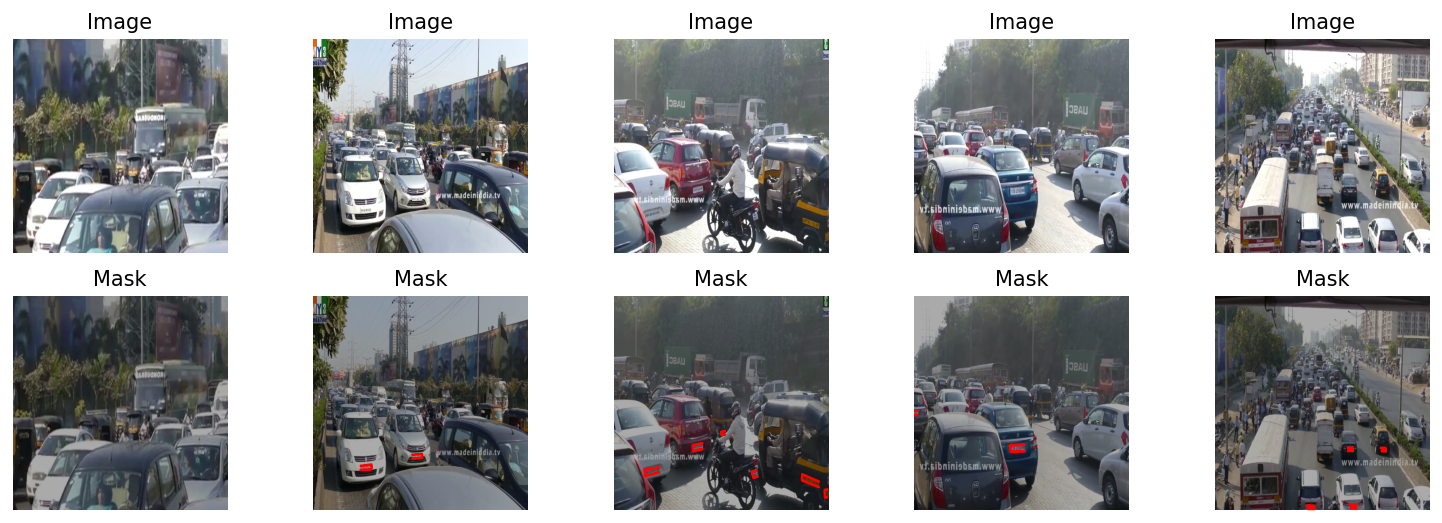

In [18]:
images_and_masks = list(dataset.take(5))

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(15, 5), dpi=125)

for i, (image, masks) in enumerate(images_and_masks):
    ax[0, i].set_title('Image')
    ax[0, i].set_axis_off()
    ax[0, i].imshow(image)
        
    ax[1, i].set_title('Mask')
    ax[1, i].set_axis_off()    
    ax[1, i].imshow(image/1.5)
   
    for channel in range(CLASSES):
        contours = measure.find_contours(np.array(masks[:,:,channel]))
        for contour in contours:
            ax[1, i].plot(contour[:, 1], contour[:, 0], linewidth=1, color=COLORS[channel])

plt.show()
plt.close()

In [19]:
train_dataset = dataset.take(2000).cache()
test_dataset = dataset.skip(2000).take(100).cache()
 
train_dataset = train_dataset.batch(2)
test_dataset = test_dataset.batch(2)

In [20]:
def input_layer():
    return tf.keras.layers.Input(shape=SAMPLE_SIZE + (3,))

def downsample_block(filters, size, batch_norm=True):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if batch_norm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample_block(filters, size, dropout=False):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    
    if dropout:
        result.add(tf.keras.layers.Dropout(0.25))
    
    result.add(tf.keras.layers.ReLU())
    return result

def output_layer(size):
    initializer = tf.keras.initializers.GlorotNormal()
    return tf.keras.layers.Conv2DTranspose(CLASSES, size, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='sigmoid')

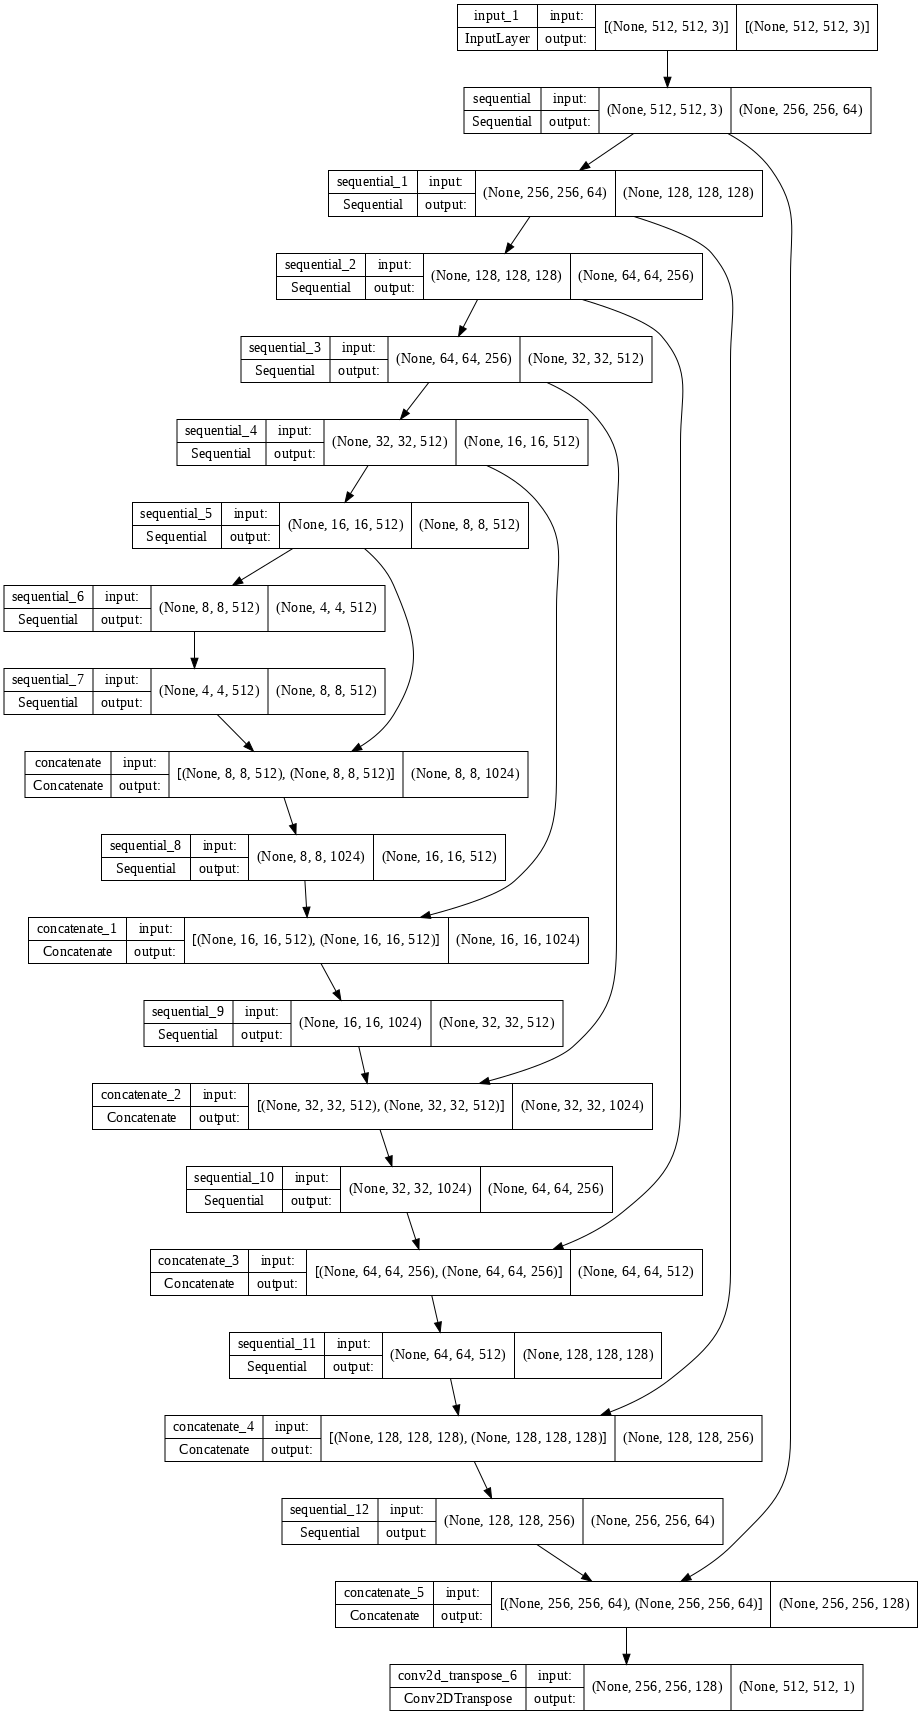

In [21]:
inp_layer = input_layer()

downsample_stack = [
    downsample_block(64, 4, batch_norm=False),
    downsample_block(128, 4),
    downsample_block(256, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
]

upsample_stack = [
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(256, 4),
    upsample_block(128, 4),
    upsample_block(64, 4)
]

out_layer = output_layer(4)

# Реализуем skip connections
x = inp_layer

downsample_skips = []

for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)
    
downsample_skips = reversed(downsample_skips[:-1])

for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    x = tf.keras.layers.Concatenate()([x, down_block])

out_layer = out_layer(x)

unet_like = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

tf.keras.utils.plot_model(unet_like, show_shapes=True, dpi=72)

In [22]:
def dice_mc_metric(a, b):
    a = tf.unstack(a, axis=3)
    b = tf.unstack(b, axis=3)
    
    dice_summ = 0
    
    for i, (aa, bb) in enumerate(zip(a, b)):
        numenator = 2 * tf.math.reduce_sum(aa * bb) + 1
        denomerator = tf.math.reduce_sum(aa + bb) + 1
        dice_summ += numenator / denomerator
        
    avg_dice = dice_summ / CLASSES
    
    return avg_dice

def dice_mc_loss(a, b):
    return 1 - dice_mc_metric(a, b)

def dice_bce_mc_loss(a, b):
    return 0.3 * dice_mc_loss(a, b) + tf.keras.losses.binary_crossentropy(a, b)

In [23]:
unet_like.compile(optimizer='adam', loss=[dice_bce_mc_loss], metrics=[dice_mc_metric])

In [24]:
history_dice = unet_like.fit(train_dataset, validation_data=test_dataset, epochs=30, initial_epoch=0)

unet_like.save_weights('/ds/unet_like')

Epoch 1/30
150/150 [==============================] - 22s 147ms/step - loss: 8.4069e-04 - dice_mc_metric: 0.9998
Epoch 2/30
150/150 [==============================] - 23s 150ms/step - loss: 8.5559e-04 - dice_mc_metric: 0.9998
Epoch 3/30
150/150 [==============================] - 22s 148ms/step - loss: 8.5426e-04 - dice_mc_metric: 0.9998
Epoch 4/30
150/150 [==============================] - 22s 146ms/step - loss: 8.5633e-04 - dice_mc_metric: 0.9998
Epoch 5/30
150/150 [==============================] - 22s 147ms/step - loss: 8.6464e-04 - dice_mc_metric: 0.9998
Epoch 6/30
150/150 [==============================] - 22s 147ms/step - loss: 8.7135e-04 - dice_mc_metric: 0.9998
Epoch 7/30
150/150 [==============================] - 22s 148ms/step - loss: 8.6310e-04 - dice_mc_metric: 0.9998
Epoch 8/30
150/150 [==============================] - 22s 148ms/step - loss: 8.5150e-04 - dice_mc_metric: 0.9998
Epoch 9/30
150/150 [==============================] - 23s 151ms/step - loss: 8.4804e-04 - dice_m

In [24]:
unet_like.load_weights('/ds/unet_like')

In [25]:
SAVING_FRAMES_PER_SECOND = 10

def format_timedelta(td):
   
    result = str(td)
    try:
        result, ms = result.split(".")
    except ValueError:
        return result + ".00".replace(":", "-")
    ms = int(ms)
    ms = round(ms / 1e4)
    return f"{result}.{ms:02}".replace(":", "-")
def get_saving_frames_durations(cap, saving_fps):
    s = []
    clip_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    for i in np.arange(0, clip_duration, 1 / saving_fps):
        s.append(i)
    return s

In [26]:
def main(video_file):
    filename, _ = os.path.splitext(video_file)
    filename += "-opencv"
    # создаем папку по названию видео файла
    if not os.path.isdir(filename):
        os.mkdir(filename)
    # читать видео файл    
    cap = cv2.VideoCapture(video_file)
    # получить FPS видео
    fps = cap.get(cv2.CAP_PROP_FPS)
    # если SAVING_FRAMES_PER_SECOND выше видео FPS, то установите его на FPS (как максимум)
    saving_frames_per_second = min(fps, SAVING_FRAMES_PER_SECOND)
    # получить список длительностей для сохранения
    saving_frames_durations = get_saving_frames_durations(cap, saving_frames_per_second)
    # запускаем цикл
    count = 0
    while True:
        is_read, frame = cap.read()
        if not is_read:
            # выйти из цикла, если нет фреймов для чтения
            break
        # получаем продолжительность, разделив количество кадров на FPS
        frame_duration = count / fps
        try:
            # получить самую раннюю продолжительность для сохранения
            closest_duration = saving_frames_durations[0]
        except IndexError:
            # список пуст, все кадры длительности сохранены
            break
        if frame_duration >= closest_duration:
            # если ближайшая длительность меньше или равна длительности кадра,
            # затем сохраняем фрейм
            frame_duration_formatted = format_timedelta(timedelta(seconds=frame_duration))
            cv2.imwrite(os.path.join(filename, f"frame{frame_duration_formatted}.jpg"), frame) 
            # удалить точку продолжительности из списка, так как эта точка длительности уже сохранена
            try:
                saving_frames_durations.pop(0)
            except IndexError:
                pass
        # увеличить количество кадров
        count += 1

In [31]:
main(path + 'MUMBAI TRAFFIC _ INDIA.mp4' )

In [34]:
rgb_colors = [
    (0,   0,   0),
    (255, 0,   0),
    (0,   255, 0),
    (0,   0,   255),
    (255, 165, 0),
    (255, 192, 203),
    (0,   255, 255),
    (255, 0,   255)
]

frames = sorted(glob.glob('/content/gdrive/MyDrive/ds/MUMBAI TRAFFIC _ INDIA-opencv/*.jpg'))

for filename in frames:
    frame = imread(filename)
    sample = resize(frame, SAMPLE_SIZE)
    
    predict = unet_like.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
    predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))
        
    scale = frame.shape[0] / SAMPLE_SIZE[0], frame.shape[1] / SAMPLE_SIZE[1]
    
    frame = (frame / 1.5).astype(np.uint8)
    
    for channel in range(1, CLASSES): 
        contour_overlay = np.zeros((frame.shape[0], frame.shape[1]))
        contours = measure.find_contours(np.array(predict[:,:,channel]))
        
        try:
            for contour in contours:
                rr, cc = polygon_perimeter(contour[:, 0] * scale[0],
                                           contour[:, 1] * scale[1],
                                           shape=contour_overlay.shape)
                
                contour_overlay[rr, cc] = 1        
            
            contour_overlay = dilation(contour_overlay, disk(1))
            frame[contour_overlay == 1] = rgb_colors[channel]
        except:
            pass

    imsave(f'/content/gdrive/MyDrive/ds/res/{os.path.basename(filename)}', frame)